In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_wego = pd.read_csv('../data/wego_headway_data.csv')
wego = raw_wego

In [3]:
wego.DATE = pd.to_datetime(wego.DATE)
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  datetime64[ns]
 4   ROUTE_ABBR                 350328 non-null  int64         
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64 

In [4]:
def uniqueId(cal_id, trip_id):
    return str(cal_id) + '_' + str(trip_id)

In [5]:
wego['unique_trip_id'] = wego.apply(lambda x: uniqueId(x.CALENDAR_ID, x.TRIP_ID), axis=1)

In [6]:
def flagger(count):
    if count == 0:
        return False
    elif count == 1:
        return True

In [7]:
wego['early'] = wego.ADJUSTED_EARLY_COUNT.apply(flagger)
wego['late'] = wego.ADJUSTED_LATE_COUNT.apply(flagger)
wego['ontime'] = wego.ADJUSTED_ONTIME_COUNT.apply(flagger)
wego['stop_cancelled'] = wego.STOP_CANCELLED.apply(flagger)
wego['prev_sched_stop_cancelled'] = wego.PREV_SCHED_STOP_CANCELLED.apply(flagger)
wego['is_relief'] = wego.IS_RELIEF.apply(flagger)

In [8]:
def percentHdwyDev(scheduled_hdwy, hdwy_dev):
    if hdwy_dev == 0:
        return 0
    elif ((scheduled_hdwy == np.NaN)
         |(hdwy_dev == np.NaN)
         |(scheduled_hdwy == 0)):
        return np.NaN
    else:
        hdwy_dev_percent = hdwy_dev / scheduled_hdwy
    return hdwy_dev_percent

In [9]:
for index, values in wego.iterrows():
    wego.loc[index, 'hdwy_dev_percent'] = percentHdwyDev(values.SCHEDULED_HDWY, values.HDWY_DEV)

In [10]:
wego.isna().sum()

CALENDAR_ID                      0
SERVICE_ABBR                     0
ADHERENCE_ID                     0
DATE                             0
ROUTE_ABBR                       0
BLOCK_ABBR                       0
OPERATOR                         0
TRIP_ID                          0
OVERLOAD_ID                      0
ROUTE_DIRECTION_NAME             0
TIME_POINT_ABBR                  0
ROUTE_STOP_SEQUENCE             11
TRIP_EDGE                        0
LATITUDE                         0
LONGITUDE                        0
SCHEDULED_TIME                   0
ACTUAL_ARRIVAL_TIME          11459
ACTUAL_DEPARTURE_TIME        11468
ADHERENCE                    11468
SCHEDULED_HDWY               75591
ACTUAL_HDWY                  84267
HDWY_DEV                     84436
ADJUSTED_EARLY_COUNT             0
ADJUSTED_LATE_COUNT              0
ADJUSTED_ONTIME_COUNT            0
STOP_CANCELLED                   0
PREV_SCHED_STOP_CANCELLED    70329
IS_RELIEF                        0
BLOCK_STOP_ORDER    

In [11]:
wego.head(20)[['SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'hdwy_dev_percent']]

,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,hdwy_dev_percent
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,35.0,37.666666,2.666666,0.076190
8,35.0,36.966666,1.966666,0.056190
9,15.0,14.516666,-0.483334,-0.032222


## **4. How much of a factor does the driver have on headway and on-time performance?**

- Make `hwdy_dev_percent` column to normalize data.

- Make an `OPERATORS` dataframe containing each `UNIQUE OPERATOR`'s `AVG % ontime` and `AVG HDWY_DEV` across all records.
    - `AVG % ontime` is derived from `AVG HDWY_DEV`.

- Visualize distribution of `UNIQUE OPERATOR`s across each performance metric.

- *Potential Considerations*:
    - Remove `ACTUAL_ARRIVAL_TIME`'s **NULL** data.
    - Remove `UNIQUE OPERATOR`'s **OUTLIERS** in `HDWY_DEV`
    - Remove `UNIQUE OPERATOR`s with few records.
        - This disregaurds new / unpracticed drivers.
    - Remove `PREV_SCHED_STOP_CANCELLED` to remove high skewed HDWY_DEV.
    - Remove `OVERLOAD_ID` to remove stops that were added on to the original schedule.

### Removed records with skewed high HDWY_DEV from conditions out of the operator's control
- **PREV_SCHED_STOP_CANCELLED**: flags whether the previous timepoint crossing was cancelled or waived. Useful for excluding records where the headway values are extremely high because the bus is just coming off a detour

In [12]:
wego = wego.loc[wego.prev_sched_stop_cancelled != True]

### Removed records that were cancelled (Lots of **NULL** and skewed values)

In [13]:
wego = wego.loc[wego.stop_cancelled != True]

### Created dataframe for each unique operator w/ their number of records

In [14]:
all_operators = wego.OPERATOR.value_counts().to_frame().reset_index()
all_operators.columns = ['operator_id', 'num_records']

### For each operator: Returns AVG HDWY_DEV with and without outliers

In [15]:
def operatorStats(operator, column):
    df = wego.loc[wego.OPERATOR == operator]
    df_desc = df[column].describe()
    q1 = df_desc['25%']
    q3 = df_desc['75%']
    iqr = q3 - q1
    upper_bound = q3 + (1.5 * iqr)
    lower_bound = q1 - (1.5 * iqr)
    df_no_outliers = df.loc[(df[column] > lower_bound)
                          & (df[column] < upper_bound)]
    
    avg_hdwy_dev_percent = df.hdwy_dev_percent.mean()
    
    avg_column = df[column].mean()
    
    avg_no_outliers = df_no_outliers[column].mean()
    
    percent_outliers = 1 - (len(df_no_outliers) / len(df))
    
    return avg_column, avg_no_outliers, percent_outliers, avg_hdwy_dev_percent

### For each operator: Returns % of records for early, on time, and late

In [16]:
def percentEarly(operator): # Takes an operator id; Returns % of time they were early.
    df = wego.loc[wego.OPERATOR == operator]
    num_rows = len(df.early)
    num_early = len(df.loc[df.early])
    return num_early / num_rows

In [17]:
def percentOnTime(operator): # Takes an operator id; Returns % of time they were on time.
    df = wego.loc[wego.OPERATOR == operator]
    num_rows = len(df.ontime)
    num_ontime = len(df.loc[df.ontime])
    return num_ontime / num_rows

In [18]:
def percentLate(operator): # Takes an operator id; Returns % of time they were late
    df = wego.loc[wego.OPERATOR == operator]
    num_rows = len(df.late)
    num_late = len(df.loc[df.late])
    return num_late / num_rows

In [19]:
wego.OPERATOR.value_counts()

OPERATOR
2352    2858
1266    2837
1147    2689
1133    2602
2424    2494
        ... 
2377       9
2256       6
56         3
473        2
0          1
Name: count, Length: 340, dtype: int64

### Removes Operators with < 389 records (1st Quartile of num_records) (commented out)

In [20]:
#op_rows_q1 = wego.OPERATOR.value_counts().describe()['25%']
#operators = all_operators.loc[all_operators.num_records > op_rows_q1]
operators = all_operators 

### Pulled avg_hdwy_dev stats for each Operator

In [21]:
for index, values in operators.iterrows(): # Populates operators dataframe with each operator's HDWY_DEV stats
    (
    operators.loc[index, 'avg_hdwy_dev'],
    operators.loc[index, 'avg_hdwy_dev_no_outliers'],
    operators.loc[index, 'percent_outliers'],
    operators.loc[index, 'avg_hdwy_dev_percent']
    ) = operatorStats(values['operator_id'], 'HDWY_DEV');

### Pulled early/ontime/late percentages for each Operator

In [22]:
operators['percent_early'] = operators.operator_id.apply(percentEarly)
operators['percent_ontime'] = operators.operator_id.apply(percentOnTime)
operators['percent_late'] = operators.operator_id.apply(percentLate)

In [23]:
operators.head(3)

,operator_id,num_records,avg_hdwy_dev,avg_hdwy_dev_no_outliers,percent_outliers,avg_hdwy_dev_percent,percent_early,percent_ontime,percent_late
0,2352,2858,-0.617348,-1.743894,0.414626,-0.024728,0.074528,0.744227,0.082225
1,1266,2837,-0.399048,-0.193497,0.216778,-0.036152,0.026084,0.877688,0.089531
2,1147,2689,1.284798,-0.224359,0.473038,0.058298,0.059130,0.904054,0.030495


## **4. How much of a factor does the driver have on headway and on-time performance?**

In [24]:
operators.describe()[['avg_hdwy_dev_percent']]

,avg_hdwy_dev_percent
count,333.000000
mean,0.033741
std,0.118863
min,-0.395035
25%,-0.025946
50%,0.022914
75%,0.086509
max,0.685068


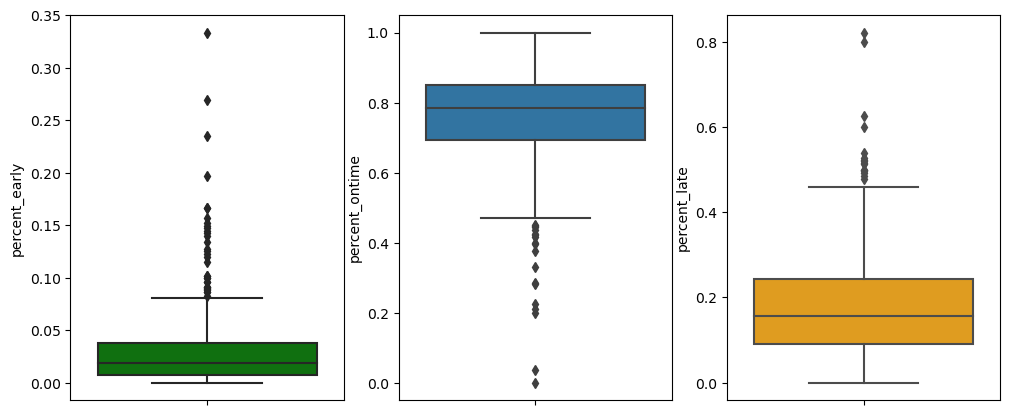

In [25]:
fig, ax =plt.subplots(1,3, figsize=(12, 5))
sns.boxplot(y=operators['percent_early'], ax=ax[0], color='green')
sns.boxplot(y=operators['percent_ontime'], ax=ax[1])
sns.boxplot(y=operators['percent_late'], ax=ax[2], color='orange')
plt.savefig('timely_boxplots.png')
fig.show()

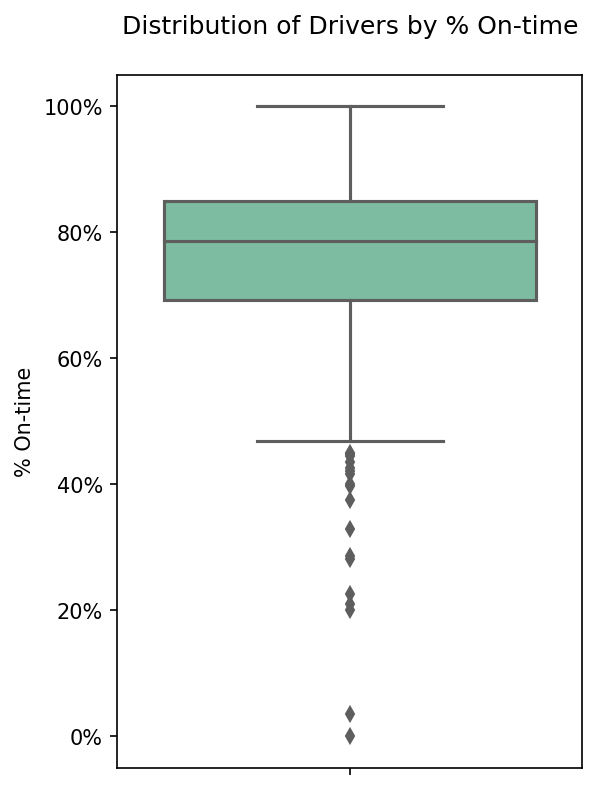

In [26]:
plt.figure(figsize=(4,6), dpi=150)
sns.boxplot(y=operators['percent_ontime']
           ,color='#73c6a1')
plt.title('Distribution of Drivers by % On-time'
         ,pad=20)
plt.ylabel('% On-time')
plt.yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]
          ,labels=['0%', '20%', '40%', '60%', '80%', '100%'])
# plt.savefig('ontime_boxplot.png'
#            ,bbox_inches='tight')
plt.show();

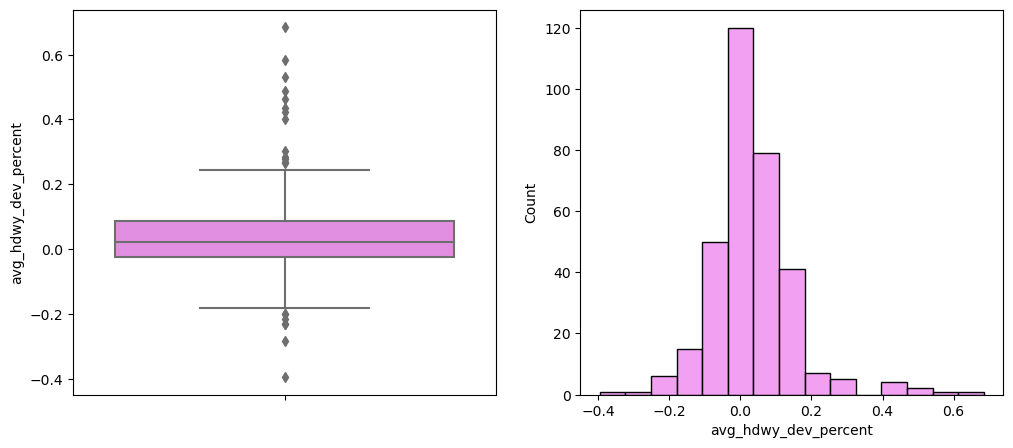

In [27]:
fig, ax =plt.subplots(1,2, figsize=(12, 5))
sns.histplot(operators['avg_hdwy_dev_percent'], ax=ax[1], bins=15, color='violet')
sns.boxplot(y=operators['avg_hdwy_dev_percent'], ax=ax[0], color='violet')
fig.show()

# Negative HDWY_DEV = Bunching, Time between buses is shorter than scheduled.
# Positive HDWY_DEV = Gapping, Time between buses is longer than scheduled.

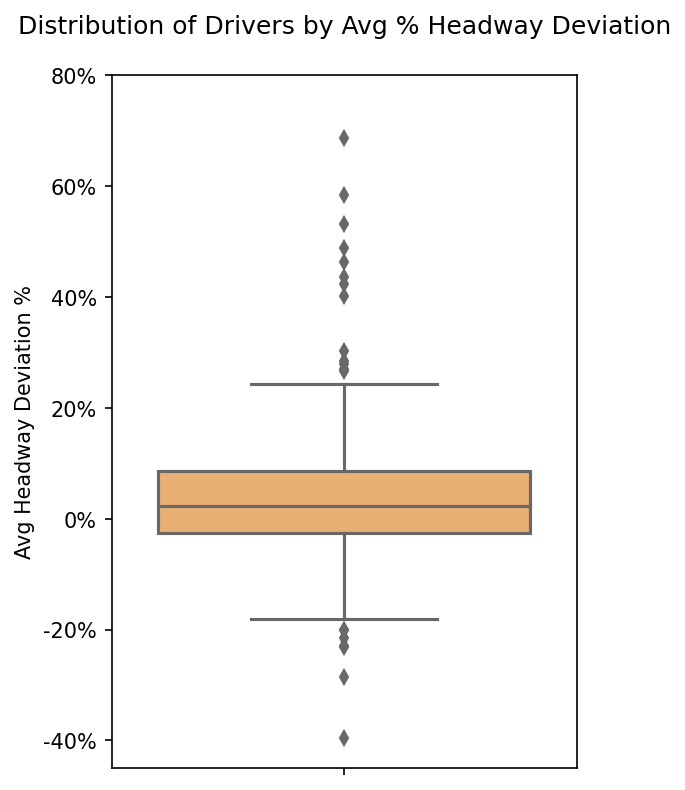

In [28]:
plt.figure(figsize=(4,6), dpi=150)
sns.boxplot(y=operators['avg_hdwy_dev_percent']
           ,color='#fbb161')
plt.title('Distribution of Drivers by Avg % Headway Deviation'
         ,pad=20)
plt.ylabel('Avg Headway Deviation %')
plt.yticks(ticks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
          ,labels=['-40%', '-20%', '0%', '20%', '40%', '60%', '80%'])
# plt.savefig('hdwy_dev_boxplot.png'
#            ,bbox_inches='tight')
plt.show();

In [29]:
operators.corr()[['num_records']]

,num_records
operator_id,-0.240031
num_records,1.000000
avg_hdwy_dev,-0.053500
avg_hdwy_dev_no_outliers,-0.097034
percent_outliers,-0.222395
avg_hdwy_dev_percent,-0.061489
percent_early,-0.129024
percent_ontime,0.254725
percent_late,-0.166831


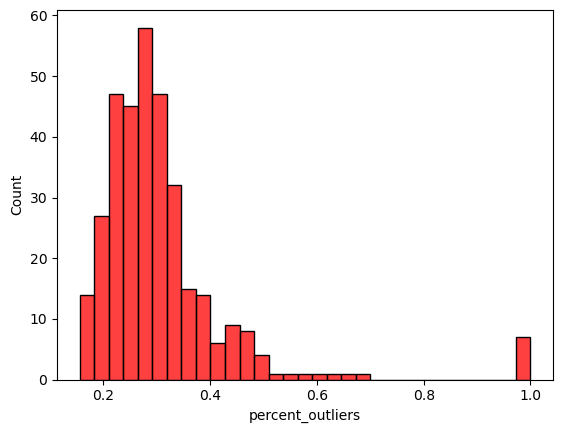

In [30]:
sns.histplot(operators['percent_outliers'], color='red');

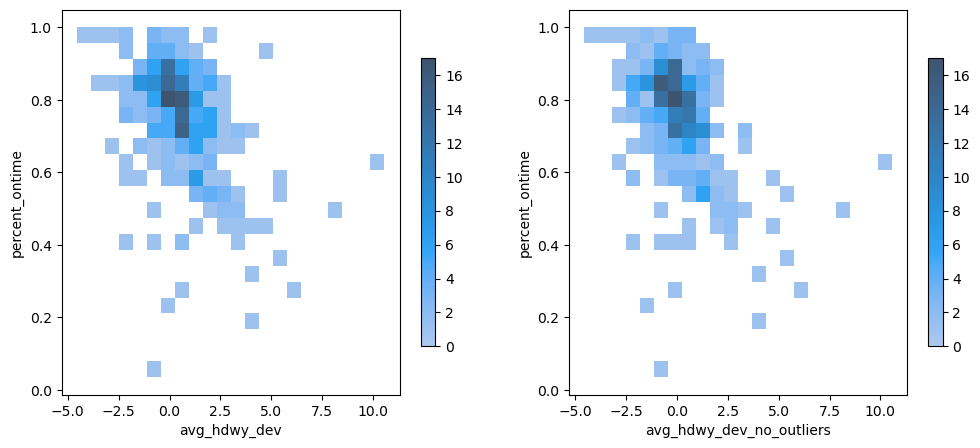

In [31]:
fig, ax =plt.subplots(1,2, figsize=(12, 5))
sns.histplot(data=operators
            ,x='avg_hdwy_dev'
            ,y='percent_ontime'
            ,cbar=True
            ,cbar_kws=dict(shrink=0.75)
            ,bins=22
            , ax=ax[0])
sns.histplot(data=operators
            ,x='avg_hdwy_dev_no_outliers'
            ,y='percent_ontime'
            ,cbar=True
            ,cbar_kws=dict(shrink=0.75)
            ,bins=22
            , ax=ax[1])
fig.show()

In [32]:
# FIXME Make box plots for each quartile of num_records in operators dataframe